In [5]:
import osmnx as ox, pandas as pd, geopandas as gpd, time, numpy as np, matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, MultiPolygon

In [2]:
# Some data preparation, removing unwanted characters from geometry

data_addresses = gpd.read_file("BRW_Adressen_Python.shp") 

# A shape file containing ~400k address coordinates of Berlin, obtained from the Berlin Open Data website: 
# http://fbinter.stadt-berlin.de/fb/?loginkey=showMap&mapId=k_wohnlagenadr2017@senstadt
# including classification into relatively poor, mid-level and good residential areas 

empty_list = []

for idx, element in enumerate(data_addresses['geometry']):
    
    empty_dict = {}
    
    text = str(element)[12:-1]
    
    x = float(text.split()[0])
    y = float(text.split()[1])
    
    point = Point((x,y))
    
    empty_dict['geometry'] = point
    empty_dict['address_ID'] = idx
    
    empty_dict['x'] = x
    empty_dict['y'] = y
    
    empty_list.append(empty_dict)
    
final_df = pd.DataFrame(empty_list)
address_df = gpd.GeoDataFrame(final_df, geometry = final_df['geometry'])
address_df.crs = {'init' :'epsg:32633'}

In [ ]:
# Same work as before

data_trees = gpd.read_file("Baeume_gesamt_Python.shp")

# A shape file containing ~360k coordinates of trees, obtained from the Berlin Open Data website: 
# http://fbinter.stadt-berlin.de/fb/?loginkey=alphaDataStart&alphaDataId=s_wfs_baumbestand@senstadt
# including information about species, type, year of planting, crown diameter (in meters), stem diameter (in cm) 
# and height (in m)

# The original file was extended by data from OpenStreetMap Berlin which also included data on supermarkets,
# public transportation, ...
# http://download.geofabrik.de/europe/germany/berlin.html ("berlin-latest-free.shp.zip")

empty_list = []

for idx, element in enumerate(data_trees['geometry']):
    
    empty_dict = {}
    
    text = str(element)[7:-1]
    
    x = float(text.split()[0])
    y = float(text.split()[1])
    
    point = Point((x,y))
    
    empty_dict['geometry'] = point
    empty_dict['tree_ID'] = idx
    
    empty_list.append(empty_dict)
    
final_df = pd.DataFrame(empty_list)
tree_df = gpd.GeoDataFrame(final_df, geometry = final_df['geometry'])
tree_df.crs = {'init' :'epsg:32633'}

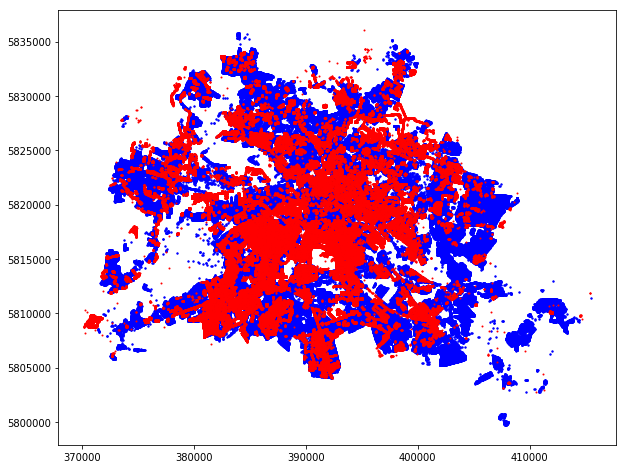

In [7]:
# Plot the coordinates

fig, ax = plt.subplots(figsize = (10,8))
address_df.plot(ax=ax, color='blue', markersize = 2)
tree_df.plot(ax=ax, color='red', markersize=1)

In [ ]:
start_time = time.time()

radius = 500 # setting an extent to how big the area to search into should be. Here: 500 metres up, down, left and right
# from centre coordinate

spatial_index = tree_df.sindex # setting a spatial index which accelerates the computations significantly

empty_list = []

#for i, row in enumerate(address_df.itertuples(), 1):

for i in range(0, len(address_df)-1):

    print (i)
    
    search_point = address_df[address_df['address_ID'] == i] 
    
    address_ID = search_point['address_ID']
    
    rectangular = Polygon([(float(search_point.x)-radius, (float(search_point.y)-radius)), 
                           (float(search_point.x)+radius, (float(search_point.y)-radius)), 
                           (float(search_point.x)+radius, (float(search_point.y)+radius)),
                           (float(search_point.x)-radius, (float(search_point.y)+radius))])  
    
    # creates a rectangular of equal size for each address coordinate 
    
    possible_matches_index = list(spatial_index.intersection(rectangular.bounds)) # reduces the map to an area containing 
    # nearby coordinates only
    
    possible_matches = tree_df.iloc[possible_matches_index]
    
    if possible_matches.empty == False:
        
        precise_matches = possible_matches[possible_matches.intersects(rectangular)] 
        
        precise_matches['Dist'] = precise_matches.apply(lambda row:  search_point.distance(row.geometry),axis=1)
        
        # computes the beeline distance between the reference point and all the remaining candidates' coordinates
        
        index = precise_matches['Dist'].idxmin(axis=1) # returns the index of the row which minimises the distance
        final_row = precise_matches.ix[[index]]
        final_row['address_ID'] = int(search_point['address_ID'])
        final_row['no_trees_within_km'] = len(precise_matches)
        
    else:
        
        address_fill = int(search_point['address_ID'])
        
        final_row = {'geometry': [np.nan], 'tree_ID': [np.nan], 'Dist': [np.nan], 'address_ID': [address_fill], 'no_trees_within_km': [np.nan]}
        
        final_row = pd.DataFrame(data=final_row)
        
        final_row = final_row.reindex([int(search_point['address_ID'])])
    
    empty_list.append(final_row)
    
final_df = pd.concat(empty_list)
final_df.to_csv("Nearest_Neighbor.csv", header = True)
    
print("--- %s seconds ---" % (time.time() - start_time))